# **FDS PROJECT PHISHING URL DETECTION**

2022BCY0012   SHRAVASTI OHOL

# Importing libraries and dataset


In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from urllib.parse import urlparse
from sklearn.preprocessing import LabelEncoder


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, classification_report

In [ ]:
#Link to dataset : https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls

In [4]:
df = pd.read_csv('phishing_site_urls.csv')

# Data cleaning and preprocessing

### dataset description

In [5]:
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [6]:
df = df.rename(columns={'URL':'url', 'Label':'label'})

In [7]:
df.isnull().sum()

,0
url,0
label,0


In [8]:
df.duplicated().sum()

42150

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.duplicated().sum()

0

In [11]:
df.shape

(507196, 2)

In [12]:
df.describe()

,url,label
count,507196,507196
unique,507195,2
top,tommyhumphreys.com/,good
freq,2,392897


### feature extraction

features extracted

1. length of url - phishing websites tend to have longer urls to hide malicious data
2. presence of https - most of the phishing websites do not use https; although some may
3. number of dots - legitimate URLs usually have fewer dots, while phishing URLs may have extra
4. number of hyphens - phishers often use hyphens to mimic legitimate URLs
5. number of subdomains - (-1) if no subdomains available
6. presence of IP address - phishers use raw IP addresses to avoid buying domain names
7. number of special characters - phishing urls include special characters to confuse victims
8. number of digits - phishing urls include lots of digits to make it seem like a legitimate one

In [13]:
# extract features from the url
def extract_features(df):
    df['url_length'] = df['url'].apply(len)
    df['num_dots'] = df['url'].apply(lambda x: x.count('.'))
    df['num_hyphens'] = df['url'].apply(lambda x: x.count('-'))
    df['num_subdomains'] = df['url'].apply(lambda x: len(urlparse(x).netloc.split('.')) - 2)
    df['has_ip'] = df['url'].apply(lambda x: bool(re.search(r'\d+\.\d+\.\d+\.\d+', x)))
    df['num_special_chars'] = df['url'].apply(lambda x: sum([x.count(c) for c in '@#$%&']))
    df['https'] = df['url'].apply(lambda x: 1 if urlparse(x).scheme == 'https' else 0)
    df['num_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in x))

    return df

df = extract_features(df)

In [14]:
df.head()

,url,label,url_length,num_dots,num_hyphens,num_subdomains,has_ip,num_special_chars,https,num_digits
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,225,6,4,-1,False,3,0,58
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,81,5,2,-1,False,1,0,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,177,7,1,-1,False,0,0,47
3,mail.printakid.com/www.online.americanexpress....,bad,60,6,0,-1,False,0,0,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,116,1,1,-1,False,0,0,21


### outlier detection

using IQR method to detect and remove outliers

In [15]:
#function to identify and handle outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

#outlier handling to relevant columns
for col in ['url_length', 'num_dots', 'num_hyphens', 'num_subdomains', 'num_special_chars', 'num_digits']:
    df = remove_outliers(df, col)

print(df.shape)

(331733, 10)


### data sampling

since the dataset is too large even after removing outliers, we will perform random sampling to work with a smaller dataset

In [16]:
# Reduce dataset size by random sampling to 2,00,000 rows
df_sampled = df.sample(n=200000, random_state=42)

In [17]:
df_sampled.shape

(200000, 10)

In [18]:
df_sampled.head()

,url,label,url_length,num_dots,num_hyphens,num_subdomains,has_ip,num_special_chars,https,num_digits
202978,jetdl.com/download/Pink+Seisyun+Woman+School+V...,good,57,1,0,-1,False,0,0,4
187211,femalemuscle.com/supersized-lesa-lewis/,good,39,1,2,-1,False,0,0,0
412903,peeperstv.com/celebs/2753/joshcharles,good,37,1,0,-1,False,0,0,4
14561,zee-plus.com/identification.html,bad,32,2,1,-1,False,0,0,0
102875,mainer.oranjetours.pl/uu/pdfmailer.html,bad,39,3,0,-1,False,0,0,0


### feature selection

In [19]:
df_sampled.isnull().sum()

,0
url,0
label,0
url_length,0
num_dots,0
num_hyphens,0
num_subdomains,0
has_ip,0
num_special_chars,0
https,0
num_digits,0


In [20]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 202978 to 188778
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   url                200000 non-null  object
 1   label              200000 non-null  object
 2   url_length         200000 non-null  int64 
 3   num_dots           200000 non-null  int64 
 4   num_hyphens        200000 non-null  int64 
 5   num_subdomains     200000 non-null  int64 
 6   has_ip             200000 non-null  bool  
 7   num_special_chars  200000 non-null  int64 
 8   https              200000 non-null  int64 
 9   num_digits         200000 non-null  int64 
dtypes: bool(1), int64(7), object(2)
memory usage: 15.4+ MB


In [21]:
# 1-good ; 0-bad
le = LabelEncoder()
df_sampled['label'] = le.fit_transform(df_sampled['label'])
df_sampled.head()

,url,label,url_length,num_dots,num_hyphens,num_subdomains,has_ip,num_special_chars,https,num_digits
202978,jetdl.com/download/Pink+Seisyun+Woman+School+V...,1,57,1,0,-1,False,0,0,4
187211,femalemuscle.com/supersized-lesa-lewis/,1,39,1,2,-1,False,0,0,0
412903,peeperstv.com/celebs/2753/joshcharles,1,37,1,0,-1,False,0,0,4
14561,zee-plus.com/identification.html,0,32,2,1,-1,False,0,0,0
102875,mainer.oranjetours.pl/uu/pdfmailer.html,0,39,3,0,-1,False,0,0,0


mutual information feature selection method to identify important features

In [22]:
X = df_sampled.drop(columns=['url','label'])
y = df_sampled['label']

# Apply Mutual Information for classification tasks
selector = SelectKBest(mutual_info_classif, k='all')
selector.fit(X, y)

# Get the Mutual Information values for each feature
mi_values = selector.scores_

# Create a DataFrame to display the MI values
mi_scores = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_values})
mi_scores = mi_scores.sort_values(by='Mutual Information', ascending=False)
print(mi_scores)

             Feature  Mutual Information
3     num_subdomains            0.034554
1           num_dots            0.015791
7         num_digits            0.012251
0         url_length            0.008606
2        num_hyphens            0.003875
4             has_ip            0.000000
5  num_special_chars            0.000000
6              https            0.000000


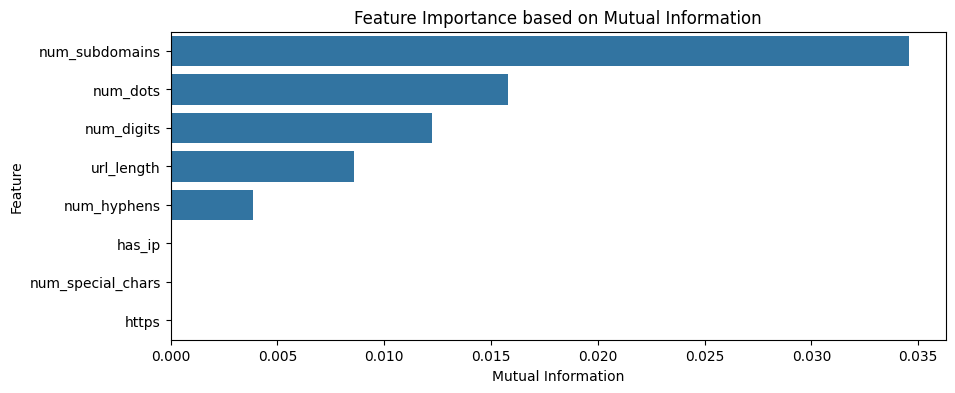

In [23]:
# visualisation for feature importance
plt.figure(figsize=(10, 4))
sns.barplot(x='Mutual Information', y='Feature', data=mi_scores)
plt.title('Feature Importance based on Mutual Information')
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.show()

based on the mutual information scores, we will drop the last feature 'has_ip'

In [24]:
df_sampled = df_sampled.drop(columns=['num_special_chars', 'has_ip'])

In [25]:
df_sampled.head()

,url,label,url_length,num_dots,num_hyphens,num_subdomains,https,num_digits
202978,jetdl.com/download/Pink+Seisyun+Woman+School+V...,1,57,1,0,-1,0,4
187211,femalemuscle.com/supersized-lesa-lewis/,1,39,1,2,-1,0,0
412903,peeperstv.com/celebs/2753/joshcharles,1,37,1,0,-1,0,4
14561,zee-plus.com/identification.html,0,32,2,1,-1,0,0
102875,mainer.oranjetours.pl/uu/pdfmailer.html,0,39,3,0,-1,0,0


## feature transformation

In [26]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3), max_features=100)
X_url_features = vectorizer.fit_transform(df_sampled['url']).toarray()

# Create a new DataFrame from the transformed data
df_url_features = pd.DataFrame(X_url_features, columns=vectorizer.get_feature_names_out())

# Reset indices of both DataFrames to avoid NaNs due to misalignment
df_sampled = df_sampled.reset_index(drop=True)
df_url_features = df_url_features.reset_index(drop=True)

df_combined = pd.concat([df_sampled.drop(columns=['url']), df_url_features], axis=1)

# Splitting the dataset into training and testing sets

In [27]:
X = df_combined.drop('label', axis=1)
y = df_combined['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
print('X train size - ', X_train.shape)
print('X test size - ', X_test.shape)
print('y train size - ', y_train.shape)
print('y test size - ', y_test.shape)

X train size -  (140000, 106)
X test size -  (60000, 106)
y train size -  (140000,)
y test size -  (60000,)


In [29]:
print('', X_train.isnull().sum())
print()
print('', X_test.isnull().sum())
print()
print('', y_train.isnull().sum())
print()
print('', y_test.isnull().sum())

 url_length        0
num_dots          0
num_hyphens       0
num_subdomains    0
https             0
                 ..
tml               0
to                0
w.                0
wi                0
ww                0
Length: 106, dtype: int64

 url_length        0
num_dots          0
num_hyphens       0
num_subdomains    0
https             0
                 ..
tml               0
to                0
w.                0
wi                0
ww                0
Length: 106, dtype: int64

 0

 0


# Selecting and Training ML Algorithms

Since we have numerical as well as categorical features and our target variable is categorical, the following ML algorithms are well suited to train and test the data

1.   Decision Trees
2.   Random Forest
3.   Logistic Regression
4.   Support Vector Machines (SVM)
5.   K-Nearest Neigbours (KNN)
6.   Naive Bayes



## 1. Decision Trees Classifier

In [30]:
param_grid = {
    'max_depth': [20], #5,10,15,20
    'min_samples_split': [50], #10, 20, 50
    'min_samples_leaf': [20], #5, 10, 20
    'max_features': ['sqrt'], #'log2'
    'criterion': ['gini'], #'entropy'
    'max_leaf_nodes': [100], #20, 50, 100
    'class_weight': ['balanced'] #None
}

In [31]:
# train the model over the training set
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [32]:
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

In [33]:
# make predictions on the test set
dt_predictions = dt_classifier.predict(X_test)

In [34]:
# evaluate the model
dt_accuracy = accuracy_score(y_test, dt_predictions)
print("Decision Tree Accuracy:", dt_accuracy)

Decision Tree Accuracy: 0.86765


## 2. Random Forest Classifier


In [35]:
param_grid = {
    'n_estimators': [500], #, 200, 500, 1000
    'max_depth': [50], #, 20, 30, 50
    'min_samples_split': [10], #, 5, 10, 20
    'min_samples_leaf': [10], #, 5, 10
    'max_features': ['sqrt'], #, 'log2'
    'bootstrap': [True], # False
    'class_weight': ['balanced'] #None
}

In [36]:
# train the model over the training set
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [37]:
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'class_weight': ['balanced'],
                         'max_depth': [50], 'max_features': ['sqrt'],
                         'min_samples_leaf': [10], 'min_samples_split': [10],
                         'n_estimators': [500]},
             scoring='accuracy', verbose=2)

In [38]:
# make predictions on the test set
rf_predictions = rf_classifier.predict(X_test)

In [39]:
# evaluate the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
print('Random Forest Accuracy:', rf_accuracy)

Random Forest Accuracy: 0.91935


## 3. Logistic Regression

In [40]:
# train the Logistic Regression model
lr_classifier = LogisticRegression(random_state=42, max_iter=10000) # Increased max_iter
lr_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [41]:
# make predictions on the test set
lr_predictions = lr_classifier.predict(X_test)

In [42]:
# evaluate the model
lr_accuracy = accuracy_score(y_test, lr_predictions)
print("Logistic Regression Accuracy:", lr_accuracy)

Logistic Regression Accuracy: 0.8563666666666667


## 4. Support Vector Machines

In [43]:
# train the SVM model
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(random_state=42)

In [44]:
# make predictions on the test set
svm_predictions = svm_classifier.predict(X_test)

In [45]:
# evaluate the model
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

SVM Accuracy: 0.8635


## 5. K-Nearest Neighbours

In [46]:
# train the model over the training set
knn_classifier = KNeighborsClassifier(n_neighbors=10)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [47]:
# make predictions on the test set
knn_predictions = knn_classifier.predict(X_test)

In [48]:
# evaluate the model
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)

KNN Accuracy: 0.8847833333333334


## 6. Naive Bayes

In [49]:
# Initialize and train the Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [50]:
# Make predictions on the test set
nb_predictions = nb_classifier.predict(X_test)

In [51]:
# Evaluate the model
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.6108833333333333


# Visualisations and Summary

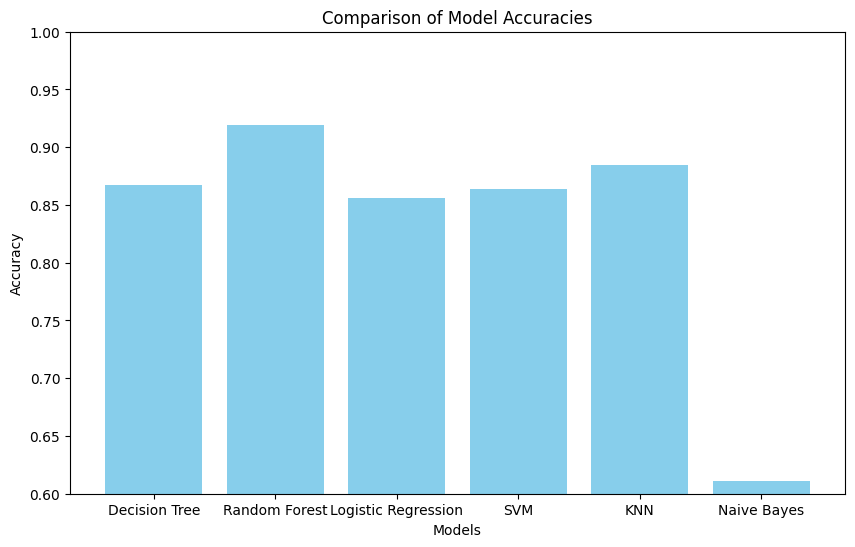

In [52]:
# Accuracy scores
models = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']
accuracies = [dt_accuracy, rf_accuracy, lr_accuracy, svm_accuracy, knn_accuracy, nb_accuracy]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.ylim(0.6, 1)  # y-axis limit for accuracy
plt.show()

In [53]:
# Print a summary table
summary_df = pd.DataFrame({'Model': models, 'Accuracy': accuracies})
summary_df

,Model,Accuracy
0,Decision Tree,0.867650
1,Random Forest,0.919350
2,Logistic Regression,0.856367
3,SVM,0.863500
4,KNN,0.884783
5,Naive Bayes,0.610883
